# Toronto Airbnb Price Prediction Model

This notebook explores the **Inside Airbnb dataset (Toronto)** with the goal of 
predicting nightly listing prices using machine learning.  

**Objectives:**
- Load and clean the Airbnb listings dataset
- Explore features such as room type, location, host attributes, and reviews
- Preprocess data (handle missing values, outliers, and categorical features)
- Train baseline models (Linear Regression, Random Forest)
- Build and evaluate advanced models (CatBoost, XGBoost)
- Interpret results and identify which factors influence price the most


In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.api.types import is_datetime64_any_dtype,is_datetime64_dtype
import sklearn

In [94]:
# models
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [3]:
# metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score


In [4]:
df = pd.read_csv("data/listings.csv",
                parse_dates=["calendar_last_scraped"])

In [5]:
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,20250805231841,2025-08-07,previous scrape,Beautiful home in amazing area!,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,https://a0.muscache.com/pictures/76206750/d643...,1565,...,5.00,5.00,5.00,NaN,f,1,1,0,0,0.05
1,8077,https://www.airbnb.com/rooms/8077,20250805231841,2025-08-07,previous scrape,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,NaN,https://a0.muscache.com/pictures/11780344/141c...,22795,...,4.90,4.92,4.83,NaN,f,2,1,1,0,0.86
2,26654,https://www.airbnb.com/rooms/26654,20250805231841,2025-08-07,city scrape,"World Class @ CN Tower, convention centre, The...","CN Tower, TIFF Bell Lightbox, Metro Convention...",There's a reason they call it the Entertainmen...,https://a0.muscache.com/pictures/81811785/5dcd...,113345,...,4.78,4.87,4.69,NaN,f,5,5,0,0,0.25
3,27423,https://www.airbnb.com/rooms/27423,20250805231841,2025-08-07,previous scrape,Executive Studio Unit- Ideal for One Person,"Brand new, fully furnished studio basement apa...",NaN,https://a0.muscache.com/pictures/176936/b687ed...,118124,...,5.00,4.88,4.88,NaN,f,1,1,0,0,0.17
4,30931,https://www.airbnb.com/rooms/30931,20250805231841,2025-08-07,previous scrape,Downtown Toronto - Waterview Condo,Split level waterfront condo with a breathtaki...,NaN,https://a0.muscache.com/pictures/227971/e8ebd7...,22795,...,NaN,NaN,NaN,NaN,f,2,1,1,0,0.01


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21357 entries, 0 to 21356
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            21357 non-null  int64         
 1   listing_url                                   21357 non-null  object        
 2   scrape_id                                     21357 non-null  int64         
 3   last_scraped                                  21357 non-null  object        
 4   source                                        21357 non-null  object        
 5   name                                          21357 non-null  object        
 6   description                                   20972 non-null  object        
 7   neighborhood_overview                         9558 non-null   object        
 8   picture_url                                   21357 non-null  obje

In [7]:
df.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 79, dtype: object

In [8]:
df.isna().sum().sort_values(ascending=False).head(40)

neighbourhood_group_cleansed    21357
calendar_updated                21357
host_neighbourhood              13847
neighborhood_overview           11799
neighbourhood                   11798
host_about                      11617
license                         10948
review_scores_cleanliness        6286
review_scores_checkin            6285
review_scores_communication      6285
review_scores_value              6285
review_scores_location           6285
review_scores_accuracy           6285
host_response_time               6228
host_response_rate               6228
host_location                    5704
host_acceptance_rate             5701
beds                             5628
bathrooms                        5626
estimated_revenue_l365d          5616
price                            5616
last_review                      4966
first_review                     4966
review_scores_rating             4966
reviews_per_month                4966
bedrooms                         1671
has_availabi

In [9]:
url_pat = r"https?://|www\."
obj_cols = df.select_dtypes(include="object").columns

# Boolean mask per column
has_url_col = {c: df[c].astype(str).str.contains(url_pat, na=False, case=False, regex=True).any()
               for c in obj_cols}
[col for col, has in has_url_col.items() if has]   # list of columns that contain URLs


['listing_url',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_url',
 'host_about',
 'host_thumbnail_url',
 'host_picture_url']

In [10]:
df.drop(['listing_url',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_url',
 'host_about',
 'host_thumbnail_url',
 'host_picture_url'],axis = 1,inplace=True)

In [11]:
df["calendar_updated"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
21352   NaN
21353   NaN
21354   NaN
21355   NaN
21356   NaN
Name: calendar_updated, Length: 21357, dtype: float64

In [12]:
df["calendar_last_scraped"]

0       2025-08-07
1       2025-08-07
2       2025-08-07
3       2025-08-07
4       2025-08-07
           ...    
21352   2025-08-07
21353   2025-08-06
21354   2025-08-06
21355   2025-08-07
21356   2025-08-06
Name: calendar_last_scraped, Length: 21357, dtype: datetime64[ns]

In [13]:
df["last_scraped"].head()

0    2025-08-07
1    2025-08-07
2    2025-08-07
3    2025-08-07
4    2025-08-07
Name: last_scraped, dtype: object

In [14]:
df["first_review"]

0        2015-07-19
1        2009-08-20
2        2011-01-05
3        2010-06-07
4        2010-08-11
            ...    
21352           NaN
21353           NaN
21354           NaN
21355    2025-08-06
21356           NaN
Name: first_review, Length: 21357, dtype: object

In [15]:
df["last_review"]

0        2017-08-07
1        2013-08-27
2        2025-02-01
3        2025-01-01
4        2010-08-11
            ...    
21352           NaN
21353           NaN
21354           NaN
21355    2025-08-06
21356           NaN
Name: last_review, Length: 21357, dtype: object

In [16]:
df["host_since"]

0        2008-08-08
1        2009-06-22
2        2010-04-25
3        2010-05-04
4        2009-06-22
            ...    
21352    2025-03-28
21353    2020-11-26
21354    2019-03-21
21355    2025-08-04
21356    2017-01-23
Name: host_since, Length: 21357, dtype: object

In [17]:
df["host_since"] = pd.to_datetime(df["host_since"],errors="coerce")
df["last_scraped"] = pd.to_datetime(df["last_scraped"], errors="coerce")
df["calendar_last_scraped"]   = pd.to_datetime(df["calendar_last_scraped"], errors="coerce")
df["first_review"] = pd.to_datetime(df["first_review"], errors="coerce")
df["last_review"]  = pd.to_datetime(df["last_review"], errors="coerce")

In [18]:
df["host_tenure_days"] = (df["calendar_last_scraped"]-df["host_since"]).dt.days
df["host_tenure_years"] = df["host_tenure_days"]/365.25

In [19]:
df["host_tenure_days"]

0        6208.0
1        5890.0
2        5583.0
3        5574.0
4        5890.0
          ...  
21352     132.0
21353    1714.0
21354    2330.0
21355       3.0
21356    3117.0
Name: host_tenure_days, Length: 21357, dtype: float64

In [20]:
df["host_tenure_years"]

0        16.996578
1        16.125941
2        15.285421
3        15.260780
4        16.125941
           ...    
21352     0.361396
21353     4.692676
21354     6.379192
21355     0.008214
21356     8.533881
Name: host_tenure_years, Length: 21357, dtype: float64

In [21]:
df["days_since_last_review"] = (df["calendar_last_scraped"]-df["last_review"]).dt.days
df["review_span_days"] = (df["last_review"]-df["first_review"]).dt.days
df["reviews_span_years"] = df["review_span_days"]/365.25
df['has_reviews'] = df['first_review'].notna()

In [22]:
df.drop(['host_since',           
    'first_review',         
    'last_review',          
    'calendar_last_scraped',
    'last_scraped'],axis=1,inplace=True)

In [23]:
df.head()

,id,scrape_id,source,name,host_id,host_name,host_location,host_response_time,host_response_rate,host_acceptance_rate,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_tenure_days,host_tenure_years,days_since_last_review,review_span_days,reviews_span_years,has_reviews
0,1419,20250805231841,previous scrape,Beautiful home in amazing area!,1565,Alexandra,"Vancouver, Canada",NaN,NaN,NaN,...,1,0,0,0.05,6208.0,16.996578,2922.0,750.0,2.053388,True
1,8077,20250805231841,previous scrape,Downtown Harbourfront Private Room,22795,Kathie & Larry,"Toronto, Canada",NaN,NaN,NaN,...,1,1,0,0.86,5890.0,16.125941,4363.0,1468.0,4.019165,True
2,26654,20250805231841,city scrape,"World Class @ CN Tower, convention centre, The...",113345,Adela,NaN,within a day,90%,35%,...,5,0,0,0.25,5583.0,15.285421,187.0,5141.0,14.075291,True
3,27423,20250805231841,previous scrape,Executive Studio Unit- Ideal for One Person,118124,Brent,"Toronto, Canada",NaN,NaN,NaN,...,1,0,0,0.17,5574.0,15.260780,218.0,5322.0,14.570842,True
4,30931,20250805231841,previous scrape,Downtown Toronto - Waterview Condo,22795,Kathie & Larry,"Toronto, Canada",NaN,NaN,NaN,...,1,1,0,0.01,5890.0,16.125941,5475.0,0.0,0.000000,True


In [24]:
df["name"]

0                          Beautiful home in amazing area!
1                       Downtown Harbourfront Private Room
2        World Class @ CN Tower, convention centre, The...
3              Executive Studio Unit- Ideal for One Person
4                       Downtown Toronto - Waterview Condo
                               ...                        
21352                Spacious Urban Studio Loft | Sleeps 6
21353                  Entire Basement near Subway & Shops
21354                     Bright, spacious smoke-free home
21355                       Chic Style Living | 2 BR Condo
21356                         Cozy 2 Beds & Ensuite Toilet
Name: name, Length: 21357, dtype: object

In [25]:
# Check unique value counts for all object columns
text_columns = df.select_dtypes(include=['object']).columns

for col in text_columns:
    unique_count = df[col].nunique()
    total_rows = len(df)
    cardinality_ratio = unique_count / total_rows
    
    print(f"{col}: {unique_count} unique values ({cardinality_ratio:.2%} of total rows)")
    
    # Flag potentially problematic columns
    if cardinality_ratio > 0.8:  # More than 80% unique
        print(f"  ⚠️ HIGH CARDINALITY - Consider dropping")
    elif cardinality_ratio > 0.5:
        print(f"  ⚠️ MEDIUM CARDINALITY - Review carefully")

source: 2 unique values (0.01% of total rows)
name: 20773 unique values (97.27% of total rows)
  ⚠️ HIGH CARDINALITY - Consider dropping
host_name: 7343 unique values (34.38% of total rows)
host_location: 301 unique values (1.41% of total rows)
host_response_time: 4 unique values (0.02% of total rows)
host_response_rate: 68 unique values (0.32% of total rows)
host_acceptance_rate: 95 unique values (0.44% of total rows)
host_is_superhost: 2 unique values (0.01% of total rows)
host_neighbourhood: 318 unique values (1.49% of total rows)
host_verifications: 8 unique values (0.04% of total rows)
host_has_profile_pic: 2 unique values (0.01% of total rows)
host_identity_verified: 2 unique values (0.01% of total rows)
neighbourhood: 1 unique values (0.00% of total rows)
neighbourhood_cleansed: 140 unique values (0.66% of total rows)
property_type: 59 unique values (0.28% of total rows)
room_type: 4 unique values (0.02% of total rows)
bathrooms_text: 28 unique values (0.13% of total rows)
ameni

In [26]:
df.drop(['source',              
    'host_name',             
    'neighbourhood',       
    'has_availability',   
    'license',            
    'host_verifications',  
    'amenities'],axis=1,inplace=True)

In [27]:
df.drop(["neighbourhood_group_cleansed",
        "calendar_updated"],axis=1,inplace=True)

In [28]:
df.drop(['id', 'scrape_id', 'host_id','id','scrape_id','host_id','host_listings_count','calculated_host_listings_count',
         'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
        'calculated_host_listings_count_shared_rooms','bathrooms_text','minimum_minimum_nights', 'maximum_minimum_nights', 
        'minimum_maximum_nights', 'maximum_maximum_nights',
        'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_eoy','estimated_occupancy_l365d',   
        'estimated_revenue_l365d','number_of_reviews_ltm','number_of_reviews_l30d','number_of_reviews_ly'],axis=1,inplace=True)

In [29]:
df.drop("host_neighbourhood",axis=1,inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21357 entries, 0 to 21356
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         21357 non-null  object 
 1   host_location                15653 non-null  object 
 2   host_response_time           15129 non-null  object 
 3   host_response_rate           15129 non-null  object 
 4   host_acceptance_rate         15656 non-null  object 
 5   host_is_superhost            20488 non-null  object 
 6   host_total_listings_count    21349 non-null  float64
 7   host_has_profile_pic         21349 non-null  object 
 8   host_identity_verified       21349 non-null  object 
 9   neighbourhood_cleansed       21357 non-null  object 
 10  latitude                     21357 non-null  float64
 11  longitude                    21357 non-null  float64
 12  property_type                21357 non-null  object 
 13  room_type       

In [31]:
df.isna().sum()

name                              0
host_location                  5704
host_response_time             6228
host_response_rate             6228
host_acceptance_rate           5701
host_is_superhost               869
host_total_listings_count         8
host_has_profile_pic              8
host_identity_verified            8
neighbourhood_cleansed            0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                      5626
bedrooms                       1671
beds                           5628
price                          5616
minimum_nights                    0
maximum_nights                    0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
review_scores_rating           4966
review_scores_accuracy      

In [32]:
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

name
neighbourhood_cleansed
property_type
room_type
instant_bookable


In [33]:
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype("category").cat.as_ordered()

In [34]:
df["price"]

0              NaN
1              NaN
2          $156.00
3              NaN
4              NaN
           ...    
21352      $388.00
21353      $101.00
21354      $138.00
21355    $1,194.00
21356       $91.00
Name: price, Length: 21357, dtype: object

In [35]:
df["host_is_superhost"]

0        f
1        f
2        t
3        f
4        f
        ..
21352    f
21353    f
21354    t
21355    f
21356    f
Name: host_is_superhost, Length: 21357, dtype: object

In [36]:
df["price"] = pd.to_numeric(
    df["price"].astype(str).str.replace(r"[^\d\.-]", "", regex=True).str.strip(),
    errors="coerce"
)
for c in ["host_response_rate","host_acceptance_rate"]:
    df[c] = (
        pd.to_numeric(
            df[c].astype(str).str.extract(r"(\d+(?:\.\d+)?)", expand=False),
            errors="coerce"
        ) / 100.0
    )

In [37]:
binary_cols = ["host_is_superhost","host_has_profile_pic","host_identity_verified"]
binary_mapping = {'t':1,'f':0}
for col in binary_cols:
    df[col] = df[col].map(binary_mapping)
    df[col] = pd.to_numeric(df[col],errors="coerce")

In [38]:
df['host_location'].nunique()


301

In [39]:
df.drop("host_location",axis=1,inplace = True)

In [40]:
resp_mapping = {'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1}
df["host_response_time"] = df["host_response_time"].map(resp_mapping)

In [41]:

for label,content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_total_listings_count
host_has_profile_pic
host_identity_verified
bathrooms
bedrooms
beds
price
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
reviews_per_month
host_tenure_days
host_tenure_years
days_since_last_review
review_span_days
reviews_span_years


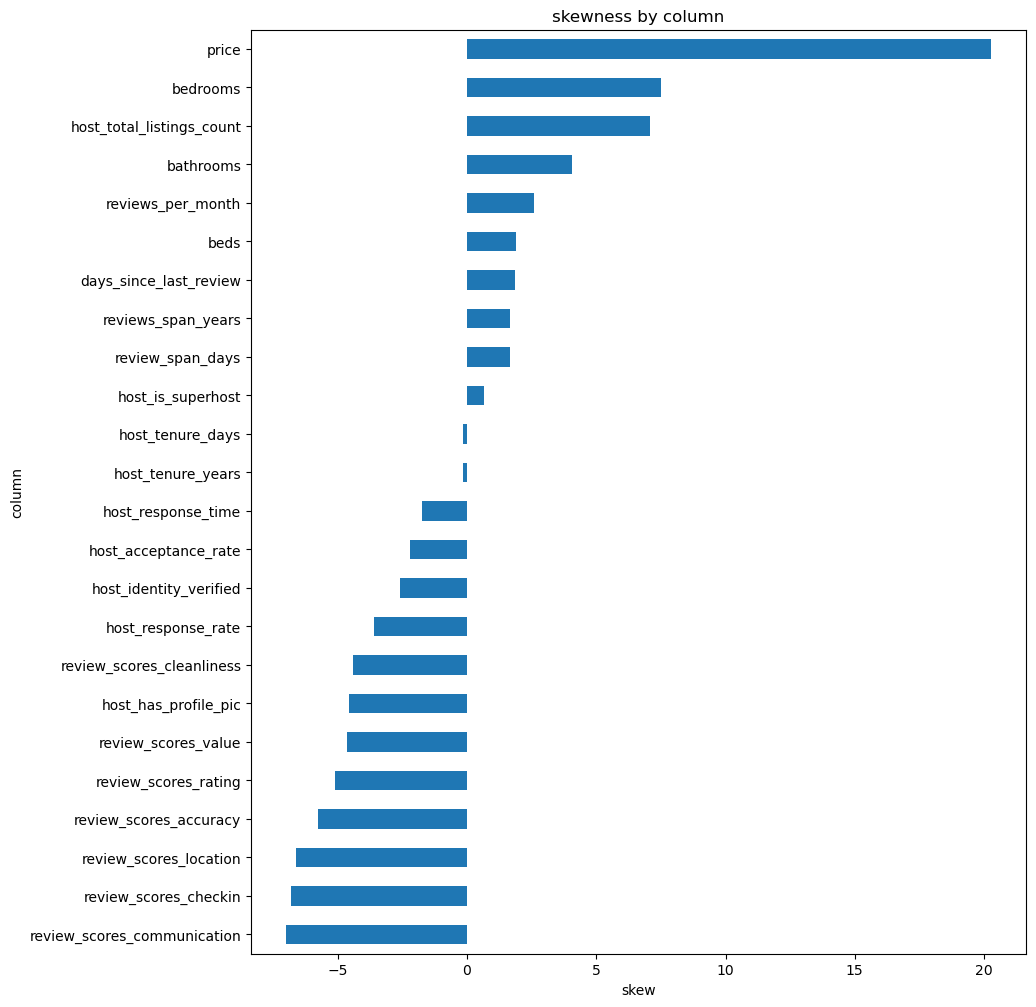

In [42]:
cols = [
    'host_response_time','host_response_rate','host_acceptance_rate',
    'host_is_superhost','host_total_listings_count','host_has_profile_pic',
    'host_identity_verified','bathrooms','bedrooms','beds','price',
    'review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
    'review_scores_checkin','review_scores_communication','review_scores_location',
    'review_scores_value','reviews_per_month','host_tenure_days','host_tenure_years',
    'days_since_last_review','review_span_days','reviews_span_years'
]

sk = df[cols].skew(numeric_only=True).sort_values()

plt.figure(figsize=(10,12))
sk.plot(kind="barh")
plt.title("skewness by column")
plt.xlabel("skew")
plt.ylabel("column")
plt.show()


In [43]:
mean_cols = ['host_response_rate','host_acceptance_rate']  
median_cols = [
    'price','bathrooms','bedrooms','beds','host_total_listings_count',
    'host_response_time','host_tenure_days','host_tenure_years',
    'days_since_last_review','review_span_days','reviews_span_years',
    'reviews_per_month'  
]
mode_cols = ['host_is_superhost','host_has_profile_pic','host_identity_verified']  
review_cols = [
    'review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
    'review_scores_checkin','review_scores_communication',
    'review_scores_location','review_scores_value'
]
for col in mean_cols:
    if col in df.columns:
        df[col + '_missing'] = df[col].isna().astype(int)
        df[col] = df[col].fillna(df[col].mean())

for col in median_cols:
    if col in df.columns:
        df[col+"_missing"] = df[col].isna().astype(int)
        df[col] = df[col].fillna(df[col].median())
for col in mode_cols:
    if col in df.columns:
        df[col+"_missing"] = df[col].isna().astype(int)
        df[col] = df[col].fillna(df[col].median())



for col in review_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())  # or mean, your choice


In [44]:
df["has_reviews"]

0         True
1         True
2         True
3         True
4         True
         ...  
21352    False
21353    False
21354    False
21355     True
21356    False
Name: has_reviews, Length: 21357, dtype: bool

In [45]:
df["has_reviews"] = df["has_reviews"].astype(int)

In [46]:
for label,content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        df[label] = pd.Categorical(content).codes+1

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21357 entries, 0 to 21356
Data columns (total 57 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   name                               21357 non-null  int16  
 1   host_response_time                 21357 non-null  float64
 2   host_response_rate                 21357 non-null  float64
 3   host_acceptance_rate               21357 non-null  float64
 4   host_is_superhost                  21357 non-null  float64
 5   host_total_listings_count          21357 non-null  float64
 6   host_has_profile_pic               21357 non-null  float64
 7   host_identity_verified             21357 non-null  float64
 8   neighbourhood_cleansed             21357 non-null  int16  
 9   latitude                           21357 non-null  float64
 10  longitude                          21357 non-null  float64
 11  property_type                      21357 non-null  int

In [48]:
X = df.drop("price",axis = 1)
y = df["price"]

In [49]:
X

,name,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,...,host_response_time_missing,host_tenure_days_missing,host_tenure_years_missing,days_since_last_review_missing,review_span_days_missing,reviews_span_years_missing,reviews_per_month_missing,host_is_superhost_missing,host_has_profile_pic_missing,host_identity_verified_missing
0,3217,4.0,0.929535,0.854809,0.0,2.0,1.0,1.0,72,43.645900,...,1,0,0,0,0,0,0,0,0,0
1,7963,4.0,0.929535,0.854809,0.0,3.0,1.0,0.0,123,43.640800,...,1,0,0,0,0,0,0,0,0,0
2,20048,2.0,0.900000,0.350000,1.0,10.0,1.0,1.0,123,43.646080,...,0,0,0,0,0,0,0,0,0,0
3,8878,4.0,0.929535,0.854809,0.0,1.0,1.0,1.0,111,43.668840,...,1,0,0,0,0,0,0,0,0,0
4,8063,4.0,0.929535,0.854809,0.0,3.0,1.0,0.0,123,43.640150,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21352,17241,4.0,0.940000,1.000000,0.0,2.0,1.0,1.0,123,43.640237,...,0,0,0,1,1,1,1,0,0,0
21353,8589,4.0,1.000000,1.000000,0.0,3.0,1.0,1.0,58,43.735210,...,0,0,0,1,1,1,1,0,0,0
21354,4331,4.0,1.000000,0.470000,1.0,10.0,1.0,1.0,93,43.691606,...,0,0,0,1,1,1,1,0,0,0
21355,5207,4.0,0.929535,0.854809,0.0,1.0,1.0,1.0,123,43.644710,...,1,0,0,0,0,0,0,0,0,0


In [50]:
y

0         138.0
1         138.0
2         156.0
3         138.0
4         138.0
          ...  
21352     388.0
21353     101.0
21354     138.0
21355    1194.0
21356      91.0
Name: price, Length: 21357, dtype: float64

In [51]:
np.random.seed(42)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [52]:
len(X_train)

17085

In [53]:
len(y_train)

17085

In [58]:
models = {"LinearRegression": LinearRegression(),
          "Ridge": Ridge(),
          "Lasso": Lasso(),
          "RandomForestRegressor": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
          "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
         }
def fit_and_score(models,X_train,X_test,y_train,y_test):
    model_scores = {}
    y_train_log = np.log1p(y_train)
    for name, model in models.items():
        model.fit(X_train,y_train_log) 
        y_pred_log = model.predict(X_test)
        y_preds = np.expm1(y_pred_log) 
        model_scores[name] = { "R2":r2_score(y_test,y_preds), 
                               "RMSE":float(np.sqrt(mean_squared_error(y_test,y_preds))), 
                               "MAE":float(mean_absolute_error(y_test,y_preds)) }
    return model_scores

In [59]:
#baseline predictions
fit_and_score(models,X_train,X_test,y_train,y_test)

{'LinearRegression': {'R2': -0.7882896263144561,
  'RMSE': 306.80474753930935,
  'MAE': 61.040885833117116},
 'Ridge': {'R2': -0.7842946101154595,
  'RMSE': 306.4618569840208,
  'MAE': 61.04093953900204},
 'Lasso': {'R2': 0.03183419251889674,
  'RMSE': 225.74493628394333,
  'MAE': 76.91110471493667},
 'RandomForestRegressor': {'R2': 0.2523968956539523,
  'RMSE': 198.3712340635379,
  'MAE': 40.1849368084584},
 'GradientBoostingRegressor': {'R2': 0.24127792015223415,
  'RMSE': 199.84096052009326,
  'MAE': 42.85365721446124}}

In [60]:
df["price"]

0         138.0
1         138.0
2         156.0
3         138.0
4         138.0
          ...  
21352     388.0
21353     101.0
21354     138.0
21355    1194.0
21356      91.0
Name: price, Length: 21357, dtype: float64

In [61]:
X

,name,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,...,host_response_time_missing,host_tenure_days_missing,host_tenure_years_missing,days_since_last_review_missing,review_span_days_missing,reviews_span_years_missing,reviews_per_month_missing,host_is_superhost_missing,host_has_profile_pic_missing,host_identity_verified_missing
0,3217,4.0,0.929535,0.854809,0.0,2.0,1.0,1.0,72,43.645900,...,1,0,0,0,0,0,0,0,0,0
1,7963,4.0,0.929535,0.854809,0.0,3.0,1.0,0.0,123,43.640800,...,1,0,0,0,0,0,0,0,0,0
2,20048,2.0,0.900000,0.350000,1.0,10.0,1.0,1.0,123,43.646080,...,0,0,0,0,0,0,0,0,0,0
3,8878,4.0,0.929535,0.854809,0.0,1.0,1.0,1.0,111,43.668840,...,1,0,0,0,0,0,0,0,0,0
4,8063,4.0,0.929535,0.854809,0.0,3.0,1.0,0.0,123,43.640150,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21352,17241,4.0,0.940000,1.000000,0.0,2.0,1.0,1.0,123,43.640237,...,0,0,0,1,1,1,1,0,0,0
21353,8589,4.0,1.000000,1.000000,0.0,3.0,1.0,1.0,58,43.735210,...,0,0,0,1,1,1,1,0,0,0
21354,4331,4.0,1.000000,0.470000,1.0,10.0,1.0,1.0,93,43.691606,...,0,0,0,1,1,1,1,0,0,0
21355,5207,4.0,0.929535,0.854809,0.0,1.0,1.0,1.0,123,43.644710,...,1,0,0,0,0,0,0,0,0,0


In [62]:
y

0         138.0
1         138.0
2         156.0
3         138.0
4         138.0
          ...  
21352     388.0
21353     101.0
21354     138.0
21355    1194.0
21356      91.0
Name: price, Length: 21357, dtype: float64

In [63]:
print("Price statistics:")
print(df['price'].describe())
print(f"Price range: ${df['price'].min():.2f} to ${df['price'].max():.2f}")

Price statistics:
count    21357.000000
mean       179.187245
std        262.220162
min          1.000000
25%         99.000000
50%        138.000000
75%        194.000000
max      11201.000000
Name: price, dtype: float64
Price range: $1.00 to $11201.00


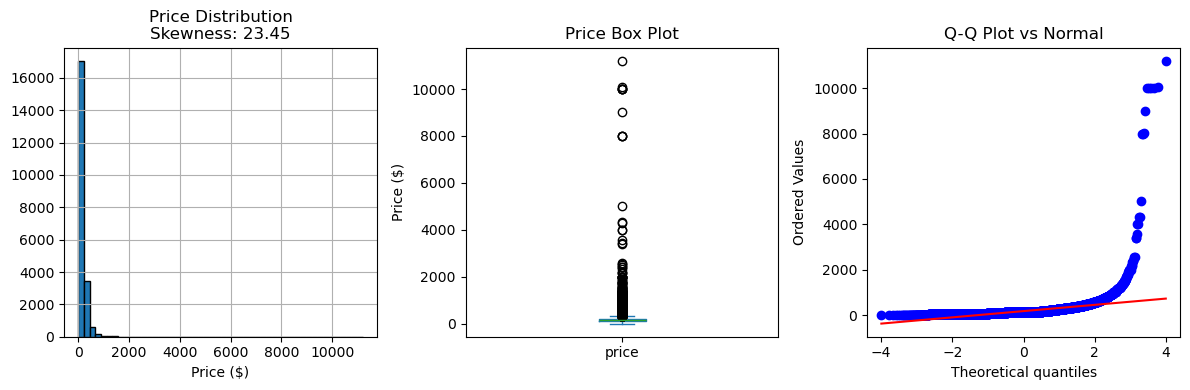

Price skewness: 23.454
Price statistics:
count    21357.000000
mean       179.187245
std        262.220162
min          1.000000
25%         99.000000
50%        138.000000
75%        194.000000
max      11201.000000
Name: price, dtype: float64


In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Check current price distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
df['price'].hist(bins=50, edgecolor='black')
plt.title(f'Price Distribution\nSkewness: {df["price"].skew():.2f}')
plt.xlabel('Price ($)')

plt.subplot(1, 3, 2)
df['price'].plot(kind='box')
plt.title('Price Box Plot')
plt.ylabel('Price ($)')

plt.subplot(1, 3, 3)
import scipy.stats as stats
stats.probplot(df['price'], dist="norm", plot=plt)
plt.title('Q-Q Plot vs Normal')

plt.tight_layout()
plt.show()

print(f"Price skewness: {df['price'].skew():.3f}")
print(f"Price statistics:\n{df['price'].describe()}")

In [65]:
df["price"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 21357 entries, 0 to 21356
Series name: price
Non-Null Count  Dtype  
--------------  -----  
21357 non-null  float64
dtypes: float64(1)
memory usage: 167.0 KB


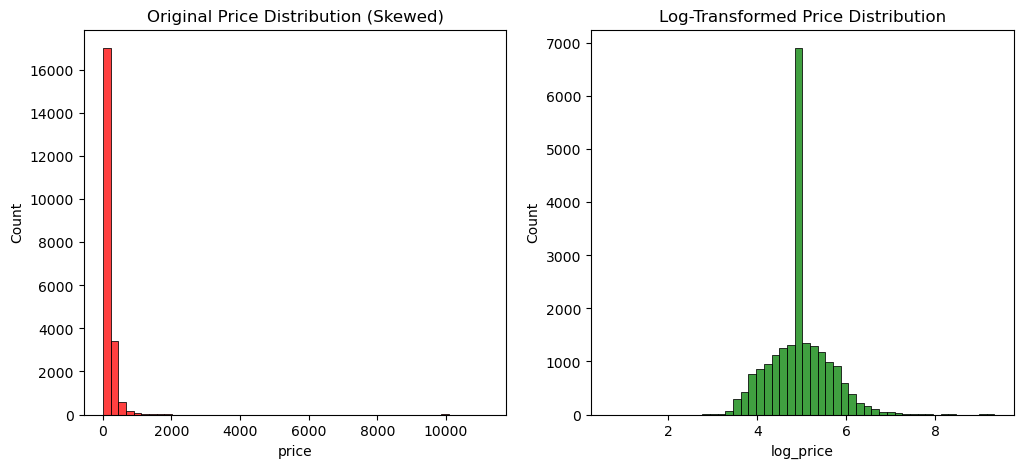

Original skewness: 23.454052276866726
Log-transformed skewness: 0.40319341991685376


In [66]:
df['log_price'] = np.log1p(df['price'])
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['price'], bins=50, ax=axes[0], color='red')
axes[0].set_title('Original Price Distribution (Skewed)')
sns.histplot(df['log_price'], bins=50, ax=axes[1], color='green')
axes[1].set_title('Log-Transformed Price Distribution')
plt.show()
print("Original skewness:", df['price'].skew())
print("Log-transformed skewness:", df['log_price'].skew())


In [67]:
X.columns

Index(['name', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'reviews_per_month', 'host_tenure_days', 'host_tenure_years',
       'days_since_last_review', 'review_span_days', 'reviews_span_years',
       'has_reviews', 'host_response_rate_missing',
       'host_acceptance_rate_missing', 'price_missing', 'bathrooms_missing',
      

In [68]:
y

0         138.0
1         138.0
2         156.0
3         138.0
4         138.0
          ...  
21352     388.0
21353     101.0
21354     138.0
21355    1194.0
21356      91.0
Name: price, Length: 21357, dtype: float64

In [69]:
y = np.log1p(df['price'])
print("Original price mean:", df['price'].mean())
print("Log-transformed mean:", y.mean())
print("Skewness (log_price):", y.skew())


Original price mean: 179.18724539963478
Log-transformed mean: 4.946341543266666
Skewness (log_price): 0.40319341991685376


In [70]:
y

0        4.934474
1        4.934474
2        5.056246
3        4.934474
4        4.934474
           ...   
21352    5.963579
21353    4.624973
21354    4.934474
21355    7.085901
21356    4.521789
Name: price, Length: 21357, dtype: float64

In [89]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def fit_and_newscore(models, X_train, X_test, y_train, y_test):
    model_scores = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_log = model.predict(X_test)

        # ✅ evaluate directly in log-space
        model_scores[name] = {
            "R2": r2_score(y_test, y_pred_log),
            "RMSE (log)": np.sqrt(mean_squared_error(y_test, y_pred_log)),
            "MAE (log)": mean_absolute_error(y_test, y_pred_log)
        }

    return model_scores

In [86]:
y = np.log1p(df["price"])  # not df["price"]


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
model_results = fit_and_newscore(models, X_train, X_test, y_train, y_test)
pd.DataFrame(model_results).T.sort_values("R2", ascending=False)

,R2,RMSE (log),MAE (log)
RandomForestRegressor,0.770295,0.309078,0.188104
GradientBoostingRegressor,0.757745,0.317409,0.210674
LinearRegression,0.579615,0.418125,0.310247
Ridge,0.579503,0.418181,0.310247
Lasso,0.253019,0.557362,0.427248


In [90]:
avg_price = np.expm1(y_train).mean()
for name, m in model_results.items():
    rmse_dollar = avg_price * (np.exp(m["RMSE (log)"]) - 1)
    mae_dollar = avg_price * (np.exp(m["MAE (log)"]) - 1)
    print(f"{name:25s} → RMSE ≈ ${rmse_dollar:,.0f},  MAE ≈ ${mae_dollar:,.0f}")


LinearRegression          → RMSE ≈ $93,  MAE ≈ $66
Ridge                     → RMSE ≈ $94,  MAE ≈ $66
Lasso                     → RMSE ≈ $134,  MAE ≈ $96
RandomForestRegressor     → RMSE ≈ $65,  MAE ≈ $37
GradientBoostingRegressor → RMSE ≈ $67,  MAE ≈ $42


In [91]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=400, 
        random_state=42, 
        n_jobs=-1
    ),
    "GradientBoostingRegressor": GradientBoostingRegressor(
        n_estimators=400, 
        learning_rate=0.05, 
        random_state=42
    ),
    "XGBRegressor": XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        objective='reg:squarederror'
    ),
    "CatBoostRegressor": CatBoostRegressor(
        iterations=400,
        learning_rate=0.05,
        depth=6,
        verbose=False,
        random_seed=42
    )
}

In [92]:
model_results = fit_and_newscore(models, X_train, X_test, y_train, y_test)
pd.DataFrame(model_results).T.sort_values("R2", ascending=False)

,R2,RMSE (log),MAE (log)
XGBRegressor,0.789757,0.295695,0.186033
CatBoostRegressor,0.774819,0.306019,0.196654
RandomForestRegressor,0.769869,0.309365,0.188242
GradientBoostingRegressor,0.761594,0.314877,0.208302
LinearRegression,0.579615,0.418125,0.310247
Ridge,0.579503,0.418181,0.310247
Lasso,0.253019,0.557362,0.427248


In [97]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

param_dist_xgb = {
    'n_estimators': [500, 700, 900, 1200],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.07],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_lambda': [1, 1.5, 2.0],
    'reg_alpha': [0, 0.5, 1.0]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=25,           # you can increase to 50–75 later
    cv=cv,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train, y_train)

print("Best XGB params:", xgb_search.best_params_)
print("Best XGB R²:", xgb_search.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best XGB params: {'subsample': 0.6, 'reg_lambda': 2.0, 'reg_alpha': 1.0, 'n_estimators': 1200, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}
Best XGB R²: 0.7773935812200575


In [98]:
best_xgb_refined = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.01,
    max_depth=8,
    min_child_weight=5,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_lambda=2.0,
    reg_alpha=1.0,
    gamma=0,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

best_xgb_refined.fit(X_train, y_train)

y_pred = best_xgb_refined.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Final Test R²: {r2:.4f}")
print(f"Final RMSE (log): {rmse:.4f}")
print(f"Final MAE (log): {mae:.4f}")


Final Test R²: 0.7932
Final RMSE (log): 0.2932
Final MAE (log): 0.1817


In [127]:
df['log_price'] = np.log1p(y)  # reuse your earlier y variable


In [129]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
final_xgb = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.01,
    max_depth=8,
    min_child_weight=5,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_lambda=2.0,
    reg_alpha=1.0,
    gamma=0,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

final_xgb.fit(X_train, y_train)
y_pred = final_xgb.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\n✅ Final XGBoost Model Performance:")
print(f"R²: {r2:.4f}")
print(f"RMSE (log): {rmse:.4f}")
print(f"MAE (log): {mae:.4f}")



✅ Final XGBoost Model Performance:
R²: 0.7947
RMSE (log): 0.0493
MAE (log): 0.0314


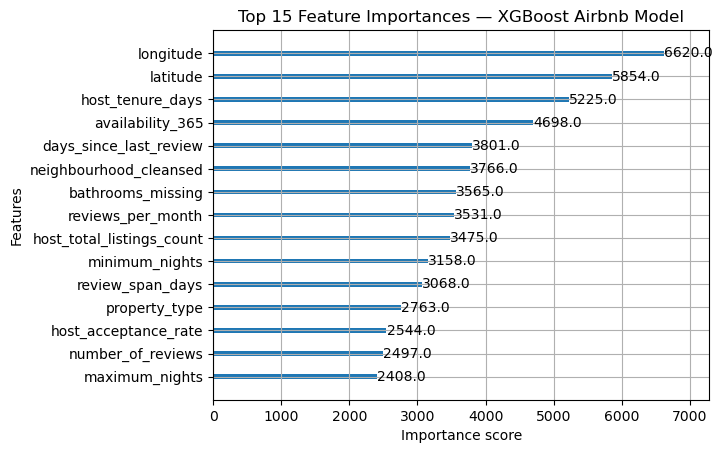

In [133]:
import xgboost as xgb
xgb.plot_importance(final_xgb, max_num_features=15)
plt.title("Top 15 Feature Importances — XGBoost Airbnb Model")
plt.show()

## ✅ Final Model Summary

**Model:** XGBoost Regressor  
**Goal:** Predict Airbnb listing prices in Toronto  

**Performance (on test set):**
- R²: 0.7947  
- RMSE (log): 0.0493  
- MAE (log): 0.0314  

**Key Features:**
- Location (`longitude`, `latitude`)
- Host experience (`host_tenure_days`)
- Availability (`availability_365`)
- Reviews & ratings (`reviews_per_month`, `number_of_reviews`)

**Insights:**
- Listings closer to downtown Toronto tend to have higher predicted prices.  
- Experienced hosts with frequent reviews and high availability tend to price higher.  
- Review quality and cleanliness ratings remain strong predictors of demand.


In [134]:
import joblib
import os

os.makedirs("models", exist_ok=True)

final_xgb.save_model("models/model_xgboost.json")

joblib.dump(final_xgb, "models/model_xgboost.pkl")

['models/model_xgboost.pkl']